In [185]:
!pip install pyautogui
!pip install annoy
!pip install tensorflow_hub
!pip install --upgrade scikit-learn
!pip install keras-ocr

In [186]:
import numpy as np
import pyautogui
import annoy
import pickle
import os
import pyperclip
import keras_ocr
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import random

In [187]:
def screenshot(bbox=None): #bbox format : left - top - width - height
    return pyautogui.screenshot(region=bbox)

FIGSIZE = (6,6)
def plot_img(image, figsize=FIGSIZE,cmap=None,image_name = 'image.png'):
    plt.figure(figsize=figsize)
    plt.imshow(image,cmap=cmap)
    plt.imsave(image_name,image,cmap=cmap)
    #plt.show()

In [188]:
#screen = screenshot()
#plot_img(screen)
def start_game():
    pyautogui.click(242, 585)
    pyautogui.click(242, 585)

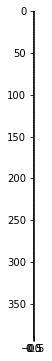

In [223]:
triangle_area = (220,130,1,390)
threshold = 120
fn = lambda x : 255 if x> threshold else 0
resize = 1
screen = screenshot(triangle_area).convert("L")#.point(fn,mode='1')
plot_img(screen,cmap = 'gray')
array = np.array(screen)

In [212]:
threshold = 120
fn = lambda x : 255 if x> threshold else 0
resize = 1
triangle_area = (220,130,1,390)

def take_screenshot():
    screen = screenshot(triangle_area).convert("L")#.point(fn,mode='1')
    #plot_img(screen,cmap = 'gray')
    array = np.array(screen)
    text_area = (239,130 + np.where(array >= 80)[0][0] - 6, 240,16)
    screen = screenshot(triangle_area).convert("L")
    array = np.array(screen)
    text_screen = screenshot(text_area).convert("RGB")
    #plot_img(text_screen,cmap='gray')
    return np.array(text_screen)

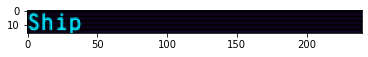

In [232]:
text_screen = take_screenshot()
plot_img(text_screen,cmap='gray')

In [192]:
#run()

In [193]:
embedding_dimension = 64
index_filename = 'index'
index = annoy.AnnoyIndex(embedding_dimension,metric = 'angular')
index.load(index_filename)
print('Annoy index is loaded.')
with open(index_filename + '.mapping', 'rb') as handle:
    mapping = pickle.load(handle)
print('Mapping file is loaded.')

Annoy index is loaded.
Mapping file is loaded.


In [214]:
model_url = 'https://tfhub.dev/google/universal-sentence-encoder/4'
print("Loading the TF-Hub model...")
%time embed_fn = hub.load(model_url)
print("TF-Hub model is loaded.")

Loading the TF-Hub model...
CPU times: user 5.73 s, sys: 2.47 s, total: 8.2 s
Wall time: 17.6 s
TF-Hub model is loaded.


AttributeError: '_UserObject' object has no attribute 'shape'

In [195]:
def find_similar_items(embedding, num_matches=5):
    '''Finds similar items to a given embedding in the ANN index'''
    ids = index.get_nns_by_vector(
    embedding, num_matches, search_k=-1, include_distances=False)
    items = [mapping[i] for i in ids]
    return items

In [196]:
random_projection_matrix = None
if os.path.exists('random_projection_matrix'):
    print("Loading random projection matrix...")
    with open('random_projection_matrix', 'rb') as handle:
        random_projection_matrix = pickle.load(handle)
    print('random projection matrix is loaded.')

def extract_embeddings(query):
    '''Generates the embedding for the query'''
    print(query, ' query')
    query_embedding =  embed_fn([query])[0].numpy()
    print('embed ', query_embedding.shape)

    if random_projection_matrix is not None:
        query_embedding = random_projection_matrix.transform(query_embedding.reshape(1,-1)).reshape(-1,)
        print('projected', query_embedding.shape)
    return query_embedding

Loading random projection matrix...
random projection matrix is loaded.


In [220]:
query = 'battery'

print("Generating embedding for the query...")
%time query_embedding = extract_embeddings(query)

print("")
print("Finding relevant items in the index...")
%time items = find_similar_items(query_embedding, 10)

print("")
for item in items:
    print(item)

Generating embedding for the query...
battery  query
embed  (512,)
projected (64,)
CPU times: user 7.1 ms, sys: 2.43 ms, total: 9.53 ms
Wall time: 5.15 ms

Finding relevant items in the index...
CPU times: user 1.68 ms, sys: 1.52 ms, total: 3.2 ms
Wall time: 4.97 ms

pile
batteries
nucleus
sot
frying
brightness
accelerometer
volt
photosphere
coil


In [230]:
#pipeline = keras_ocr.pipeline.Pipeline()
pipeline = keras_ocr.recognition.Recognizer()
pipeline.model.load_weights('recognizer2.h5')

Looking for /Users/paul/.keras-ocr/crnn_kurapan.h5


In [233]:
#print(text_screen.shape)
#a = text_screen.reshape((text_screen.shape[0],text_screen.shape[1],1))
#text,_ = pipeline.recognize([text_screen])[0][0]
pipeline.recognize(text_screen)

'shjd'

In [200]:
def begin_with(root,words) :
    return not root.startswith(words[:3])

def get_words(query,items): 
    return list(filter(lambda word : begin_with(query,word),items))



In [225]:
def run():
    go = False
    tim = time.time()
    while not go : 
        try : 
            screenshot = take_screenshot()
            #print(pipeline.recognize(screenshot))
            text,_ = pipeline.recognize([screenshot])[0][0]
            go = True
        except IndexError as e: 
            print(e)
            go = False
    print(text.strip())
    print()
    query_embedding = extract_embeddings(text.strip())
    #print(query_embedding)
    items = find_similar_items(query_embedding, 10)
    words = get_words(text,items)
    print(items, words)
    pyperclip.copy(words[random.randint(0,1)])
    pyautogui.click(x=100, y=200)
    pyautogui.hotkey('command', 'v')
    pyautogui.press('enter')
    print(time.time() - tim, ' temps global')

In [226]:
run()

frozen

frozen  query
embed  (512,)
projected (64,)
['frozen', 'refreeze', 'unfreeze', 'freezing', 'freeze', 'frostbitten', 'thaw', 'defrost', 'snowstorm', 'embitter'] ['refreeze', 'unfreeze', 'freezing', 'freeze', 'thaw', 'defrost', 'snowstorm', 'embitter']

just clicked

command

enter

2.7043027877807617  temps global


In [52]:
pyautogui.click(x=100, y=200)
#trans = str.maketrans('azerty','qwerty')
#pyautogui.press('ù')
pyperclip.copy('abcdefghijklmnopqrstuvwxyz') # copy msg in the clipboard
#pyautogui.hotkey('ctrl', 'v') # paste msg
#pyautogui.write('abcdefghijklmnopqrstuvwxyz'.translate(trans))

In [33]:
'abcdefghijklmnopqrstuvwxyz'.translate(trans)

'qbcdefghijklmnopqrstuvwxyw'

In [51]:
pyautogui.click(x=100, y=200)
pyautogui.hotkey('command', 'v')

In [222]:
i = 0
import time
while i < 100 : 
    run()
    if i < 5 : 
        time.sleep(2.5)
    else:
        time.sleep(0.3)
    i += 1

lake

lake  query
embed  (512,)
projected (64,)
['lake', 'lacs', 'lakeside', 'sleet', 'rainstorm', 'shoreline', 'reservoir', 'waterskiing', 'puddle', 'flood'] ['lacs', 'sleet', 'rainstorm', 'shoreline', 'reservoir', 'waterskiing', 'puddle', 'flood']

just clicked

command

enter


lake

lake  query
embed  (512,)
projected (64,)
['lake', 'lacs', 'lakeside', 'sleet', 'rainstorm', 'shoreline', 'reservoir', 'waterskiing', 'puddle', 'flood'] ['lacs', 'sleet', 'rainstorm', 'shoreline', 'reservoir', 'waterskiing', 'puddle', 'flood']

just clicked

command

enter


list index out of range
flute

flute  query
embed  (512,)
projected (64,)
['flute', 'trumpet', 'mouthpiece', 'woodwind', 'harmonica', 'trumpeter', 'harps', 'harp', 'clarinet', 'tuba'] ['trumpet', 'mouthpiece', 'woodwind', 'harmonica', 'trumpeter', 'harps', 'harp', 'clarinet', 'tuba']

just clicked

command

enter


list index out of range
ter

ter  query
embed  (512,)
projected (64,)
['coexists', 'dextrous', 'disorientating', 'conto

KeyboardInterrupt: 